In [24]:
import author
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.linear_model import Ridge,Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
engine = author.processed_engine

In [25]:
df = pd.read_sql("SELECT * FROM BTCUSD_1d",engine)
df.set_index(df.columns[0],inplace=True)
df

,Price,Gap,Rsi,Macd,Macd_Signal,Vwap,Volume,Fast_k,Fast_d
time,,,,,,,,,
2019-12-14,7124.673828,0.029818,28.706879,-54.808956,-83.880497,7365.954126,17137029730,4.250059,6.732319
2019-12-15,7152.301758,0.037072,31.457886,-62.217280,-91.850574,7353.061529,16881129804,27.827874,13.774893
2019-12-16,6932.480469,0.038745,23.641241,-72.690585,-114.583808,7324.720257,20213265950,3.429340,10.322872
2019-12-17,6640.515137,0.057089,17.442055,-89.028394,-154.379629,7277.248387,22363804217,4.547204,8.396346
2019-12-18,7276.802734,0.120020,48.893805,-97.830994,-133.041395,7277.208327,31836522778,61.223553,26.013362
...,...,...,...,...,...,...,...,...,...
2022-02-24,38332.609375,0.130868,41.974985,-345.278918,-849.822434,32471.703882,46383802093,37.944657,17.120962
2022-02-25,39214.218750,0.039856,45.786221,-437.395225,-805.860454,32477.196559,26545599159,10.804026,15.015317
2022-02-26,39105.148438,0.033662,45.389014,-504.103075,-770.934477,32480.747539,17467554129,3.944096,11.324910


In [26]:
df.describe()

,Price,Gap,Rsi,Macd,Macd_Signal,Vwap,Volume,Fast_k,Fast_d
count,835.000000,835.000000,835.000000,835.000000,835.000000,835.000000,8.350000e+02,835.000000,835.000000
mean,29588.790499,0.054611,54.504401,279.528556,276.805377,17919.923423,3.881201e+10,14.205656,14.198512
std,19262.170973,0.046005,14.190109,1540.671685,1623.580209,9855.539490,2.023382e+10,11.609432,5.343902
min,4970.788086,0.008354,13.683424,-4399.887547,-5256.404736,7265.574008,1.225260e+10,0.000000,2.079764
25%,9727.806641,0.028067,44.435620,-354.644579,-390.544265,8438.712332,2.605945e+10,5.721381,10.494438
50%,32366.392578,0.043490,53.953059,204.811686,183.401822,13667.550894,3.481514e+10,11.187654,13.430330
75%,46911.248047,0.063492,64.602322,1036.867013,978.401533,27943.202674,4.635046e+10,19.132731,17.029627
max,67566.828125,0.631387,90.981119,4605.095796,5277.859816,32489.895526,3.509679e+11,66.738595,38.269247


<AxesSubplot:>

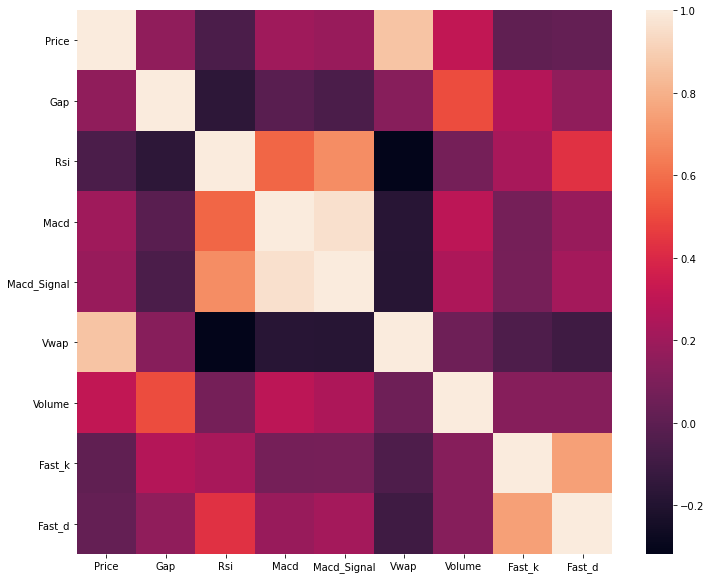

In [27]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr())

#### RSI와 속성들간의 관계

vwap와 rsi가 음의 상관관계를 띄는 것을 확인할 수 있다. <br>
VWAP는 거래량을 고려한 가격을 의미하고 RSI는 특정 기간 동안 상승량과 하락량 중 무엇이 더 큰지를 나타내주는 지표이다.<br>
RSI와 VWAP가 음의 관계를 띄는 이유는 RSI는 상승과 하락이 잦은 반면 VWAP는 꾸준히 우상향을 유지했기 때문인 것으로 보인다.

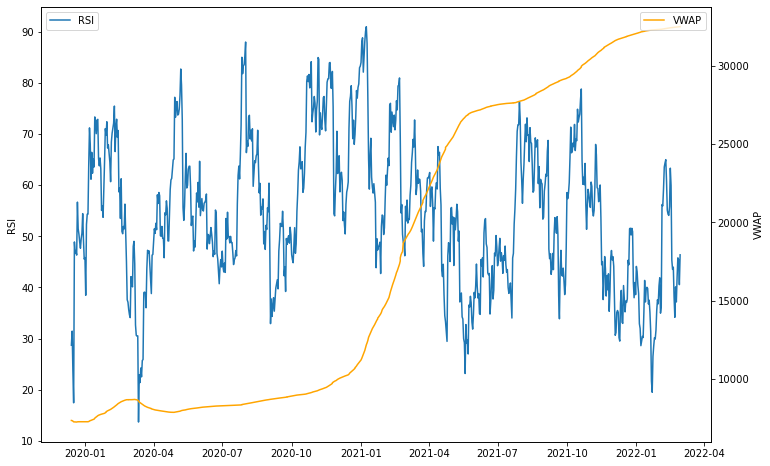

In [19]:
fig,ax1 = plt.subplots(figsize=(12,8))
ax1.plot(df['Rsi'],label='RSI')
ax1.set_ylabel("RSI")
plt.legend(loc="upper left")
ax2 = ax1.twinx()
ax2.plot(df['Vwap'],color='orange',label='VWAP')
ax2.set_ylabel("VWAP")
plt.legend(loc="upper right")

이번에는 RSI와 양의 관계를 갖는 MACD를 시각화 해보자.RSI는 MACD와 몹시 흡사하게 움직인다는 것을 확인 할 수 있다. MACD는 이평선의 수렴과 발산을 통해 과매수, 과매도를 보여주는 지표이다. 일반적으로 시그널선의 아래에 위치하면 과매도, 시그널 선의 위편에 위치하면 과매수 상태로 여긴다.


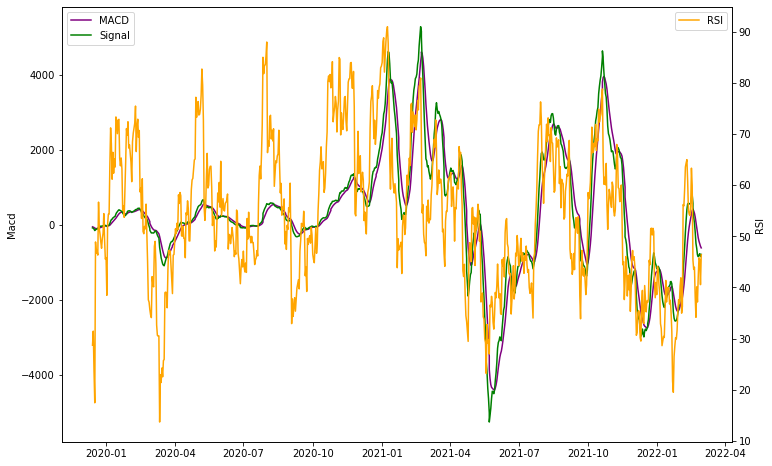

In [30]:
fig,ax1 = plt.subplots(figsize=(12,8))
ax1.plot(df['Macd'],label='MACD',color='purple')
ax1.plot(df['Macd_Signal'],label='Signal',color='green')
ax1.set_ylabel("Macd")
plt.legend(loc="upper left")
ax2 = ax1.twinx()
ax2.plot(df['Rsi'],color='orange',label='RSI')
ax2.set_ylabel("RSI")
plt.legend(loc="upper right")

정말 시그널 선과의 교차가 발생하면 과매수 혹은 과매도 상태가 되며 가격의 상승과 하락을 예측할 수 있는지 확인해보자.

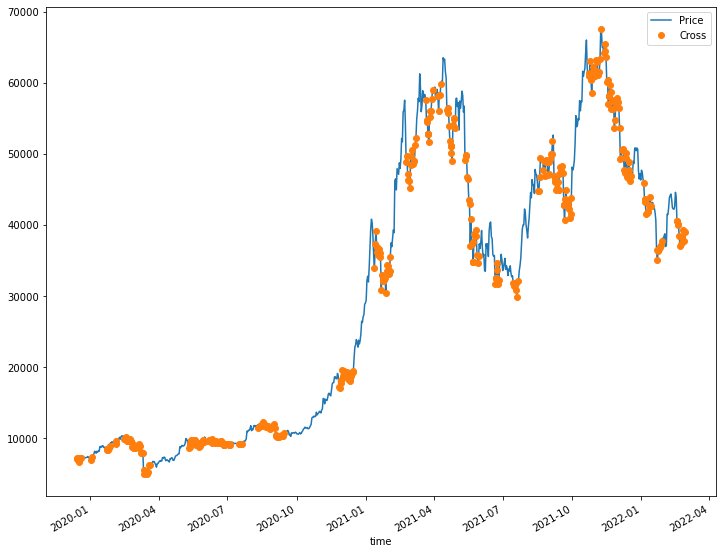

In [44]:
macd = df['Macd']
sig = df['Macd_Signal']
plt.figure(figsize=(12,10))
df['Price'].plot(label='Price')
df['Price'].loc[macd[macd - sig > 0].index].plot(label="Cross",marker='o',linestyle='None')
plt.legend()


주황색은 MACD를 통한 상승 신호가 발생한 포인트들을 말한다. <br>
이익을 보는 부분들도 분명 존재하지만, 잘못된 포인트들도 많이 존재한다. <br>
1월~4월 까지는 크로스 전략이 괜찮았으나, 코인 장이 무너지기 시작하면서 크로스만을 신호로 매수를 진행하기는 어려워졌다.

이제 하락을 예측하는건 어떤지 확인해보자.


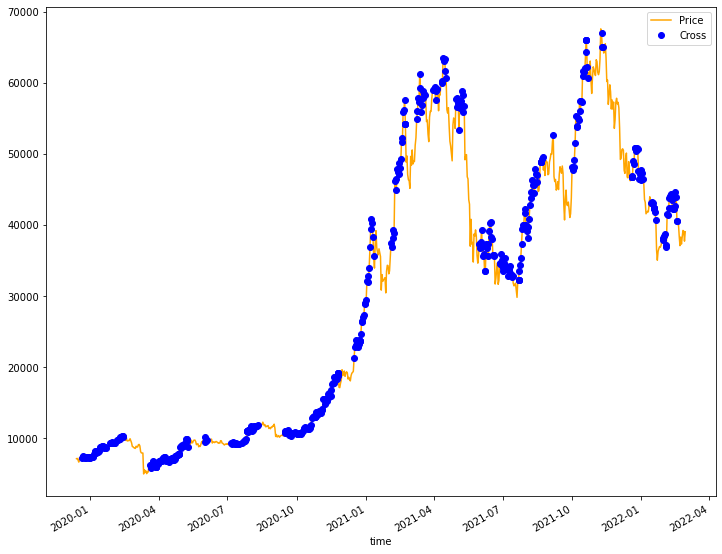

In [46]:
macd = df['Macd']
sig = df['Macd_Signal']
plt.figure(figsize=(12,10))
df['Price'].plot(label='Price',color='orange')
df['Price'].loc[macd[macd - sig < 0].index].plot(label="Cross",marker='o',linestyle='None',color='blue')
plt.legend()


하락은 정말 잘 예측하지 못하는 듯 보인다. 이는 아마 비트코인이 조사기간 내 추세가 꾸준히 좋았기 때문이라 생각한다. <br>
추세가 하락으로 전환한 최근에 들어서 비교적 그럴듯한 결과를 보이고 있다.

이제 stocastic 속성들과 어떤 상관관계를 갖는지 시각화 해보자.

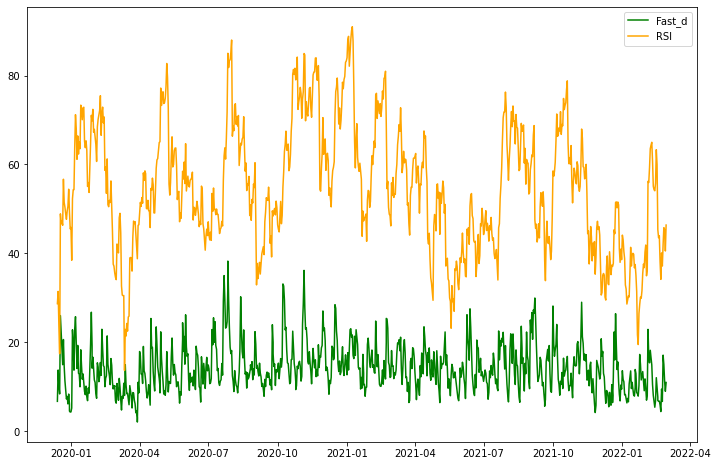

In [53]:
fig,ax1 = plt.subplots(figsize=(12,8))
# ax1.plot(df['Fast_k'],label='Fast_k',color='purple',linestyle='None',marker='o')
ax1.plot(df['Fast_d'],label='Fast_d',color='green')
ax1.plot(df['Rsi'],color='orange',label='RSI')
plt.legend(loc="upper right")

gap은 volume과 양의 상관 관계를 띄는데 거래량이 증가 할 수록 고점과 저점간의 간극이 커진다는 것을 확인할 수 있다.<br>
이는 당연한 현상으로 거래가 폭발적으로 증가하면 방향은 상,하 어느 방향이든 강하게 움직일 가능성이 높다.<br>
volume은 gap과 유사한 분포를 띈다. 

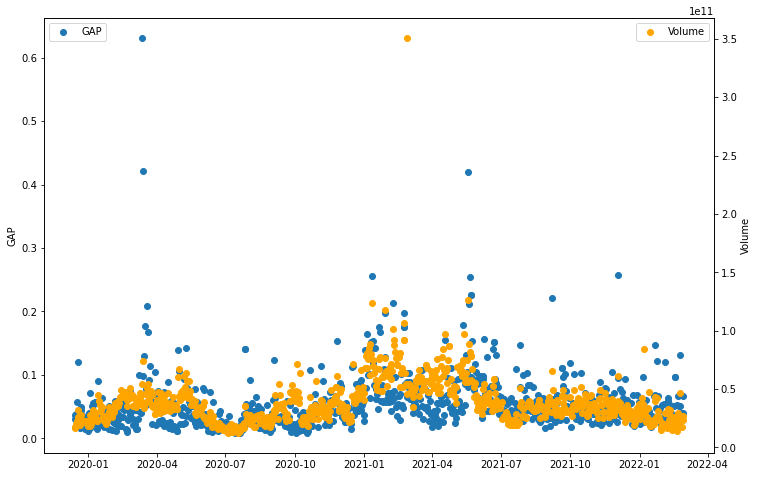

In [21]:
fig,ax1 = plt.subplots(figsize=(12,8))
index = df.index
ax1.scatter(index, df['Gap'],label='GAP')
ax1.set_ylabel("GAP")
plt.legend(loc="upper left")
ax2 = ax1.twinx()
ax2.scatter(index, df['Volume'],color='orange',label='Volume')
ax2.set_ylabel("Volume")
plt.legend(loc="upper right")

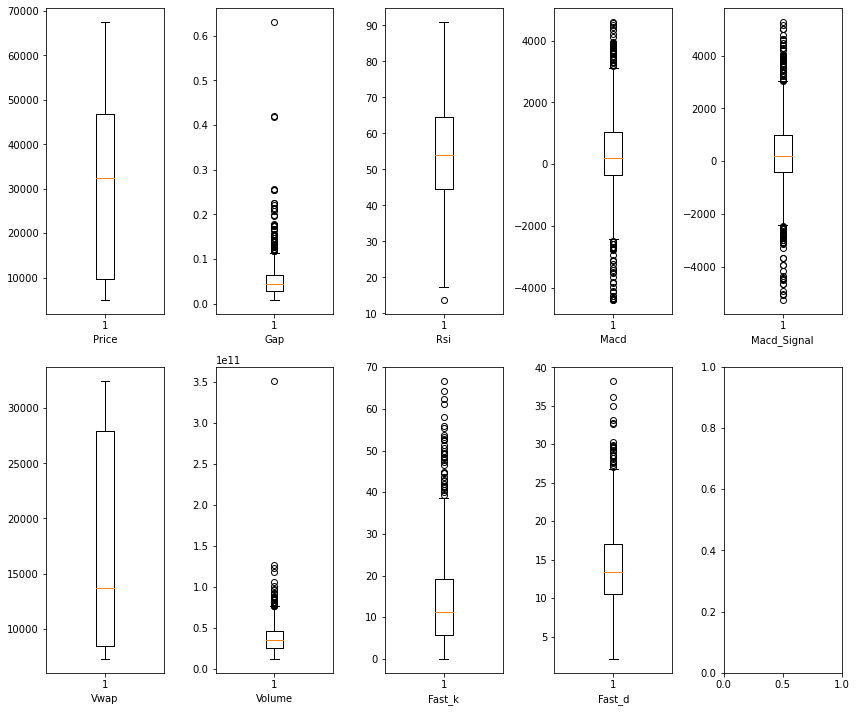

In [54]:
fig,axes = plt.subplots(2,5,figsize=(12,10))
for i, c in enumerate(df.columns,start=1):
    plt.subplot(2,5,i)
    plt.boxplot(df[c])
    plt.xlabel(c)
plt.tight_layout()

iqr 범위를 벗어나는 데이터가 몇개 있는지 확인해보자. gap, vwap, macd가 특히 심하다.


In [56]:
from collections import defaultdict
def remove_outliers(df):
    q_1 = df.apply(lambda x: np.quantile(x, 0.25))
    q_3 = df.apply(lambda x: np.quantile(x, 0.75))
    iqr = q_3 - q_1
    min_p = q_1 - 1.5 * iqr
    max_p = q_3 + 1.5 * iqr
    outliers = np.where((df < min_p) | (df > max_p))
    row,col = outliers
    df = df.drop(df.index[row])
    return df



In [57]:
q_1 = df.apply(lambda x: np.quantile(x,0.25))
q_3 = df.apply(lambda x: np.quantile(x,0.75))
iqr = q_3 - q_1
min_p = q_1 - 1.5 * iqr
max_p = q_3 + 1.5 * iqr
print(min_p,max_p)

Price         -4.604736e+04
Gap           -2.506991e-02
Rsi            1.418557e+01
Macd          -2.441912e+03
Macd_Signal   -2.443963e+03
Vwap          -2.081802e+04
Volume        -4.377061e+09
Fast_k        -1.439564e+01
Fast_d         6.916550e-01
dtype: float64 Price          1.026864e+05
Gap            1.166286e-01
Rsi            9.485238e+01
Macd           3.124134e+03
Macd_Signal    3.031820e+03
Vwap           5.719994e+04
Volume         7.678697e+10
Fast_k         3.924976e+01
Fast_d         2.683241e+01
dtype: float64


In [58]:
outliers = np.where((df < min_p) | (df > max_p))
outliers

(array([  4,   4,  21,  24,  46,  61,  68,  92,  92,  93,  95,  96,  99,
        100, 128, 142, 142, 153, 176, 212, 227, 227, 228, 228, 229, 233,
        233, 233, 234, 234, 234, 235, 251, 251, 271, 273, 294, 309, 309,
        310, 311, 336, 337, 338, 338, 339, 360, 364, 364, 380, 380, 381,
        398, 399, 400, 400, 401, 401, 402, 403, 403, 404, 404, 404, 404,
        405, 405, 406, 406, 406, 406, 407, 407, 407, 407, 408, 408, 408,
        409, 409, 409, 410, 410, 411, 411, 411, 412, 412, 413, 413, 414,
        415, 417, 418, 418, 425, 426, 426, 436, 436, 436, 437, 438, 439,
        439, 440, 441, 442, 443, 443, 444, 444, 444, 445, 445, 445, 446,
        446, 447, 447, 448, 448, 449, 449, 450, 450, 450, 450, 451, 451,
        451, 451, 452, 452, 452, 452, 453, 453, 454, 454, 455, 455, 456,
        457, 470, 471, 472, 502, 503, 505, 507, 507, 512, 513, 532, 533,
        536, 537, 538, 539, 539, 539, 540, 540, 540, 541, 541, 541, 541,
        542, 542, 543, 543, 543, 543, 544, 544, 544

In [59]:
from collections import defaultdict
row,col = outliers
outliers_cols = defaultdict(list)
for r,c in zip(row,col):
    outliers_cols[df.columns[c]].append(r)
outliers_cols

defaultdict(list,
            {'Gap': [4,
              92,
              93,
              95,
              96,
              99,
              100,
              142,
              153,
              233,
              234,
              273,
              360,
              398,
              400,
              401,
              404,
              406,
              407,
              408,
              409,
              411,
              417,
              418,
              425,
              426,
              436,
              450,
              451,
              452,
              507,
              532,
              536,
              539,
              540,
              541,
              543,
              544,
              545,
              549,
              561,
              565,
              573,
              574,
              575,
              578,
              610,
              654,
              679,
              745,
              795,
             

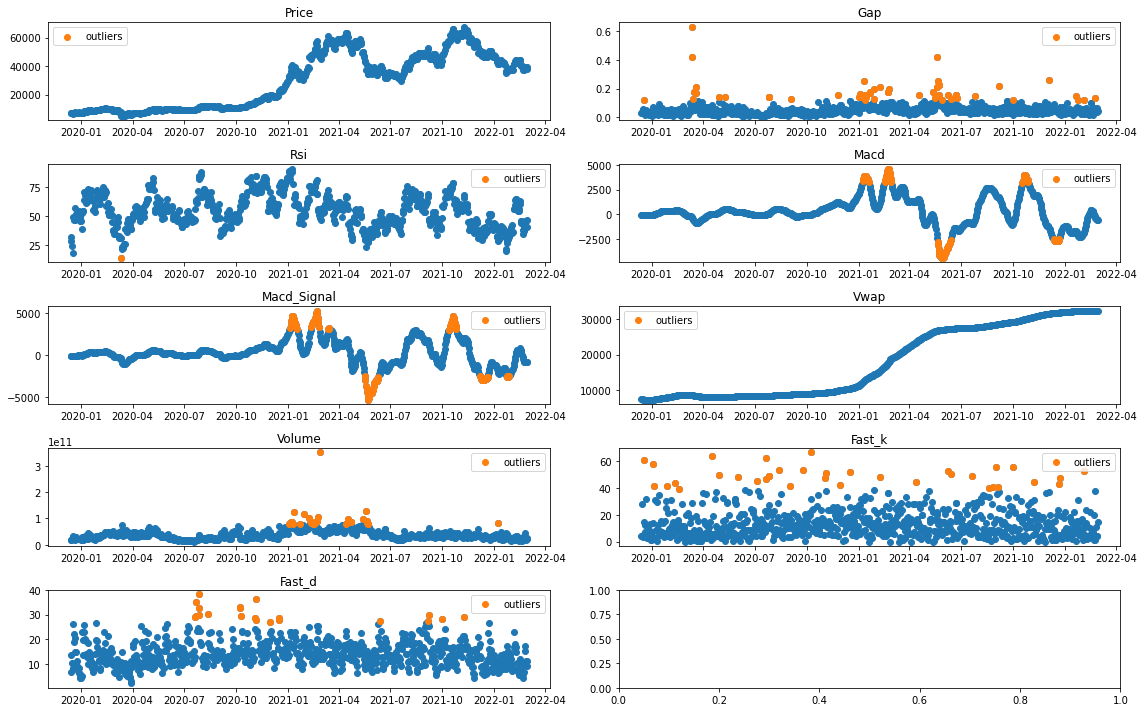

In [60]:
fig,axes = plt.subplots(5,2,figsize=(16,10))
for i, c in enumerate(df.columns,start=1):
    index = df[c].index
    plt.subplot(5,2,i)
    plt.title(c)
    plt.scatter(x=index,y=df[c])
    plt.scatter(x=df[c].iloc[outliers_cols[c]].index, y=df[c].iloc[outliers_cols[c]],label='outliers')
    plt.legend()
plt.tight_layout()

아웃라이어를 제거해준다.

In [61]:
df = df.drop(df.index[row])
df

,Price,Gap,Rsi,Macd,Macd_Signal,Vwap,Volume,Fast_k,Fast_d
time,,,,,,,,,
2019-12-14,7124.673828,0.029818,28.706879,-54.808956,-83.880497,7365.954126,17137029730,4.250059,6.732319
2019-12-15,7152.301758,0.037072,31.457886,-62.217280,-91.850574,7353.061529,16881129804,27.827874,13.774893
2019-12-16,6932.480469,0.038745,23.641241,-72.690585,-114.583808,7324.720257,20213265950,3.429340,10.322872
2019-12-17,6640.515137,0.057089,17.442055,-89.028394,-154.379629,7277.248387,22363804217,4.547204,8.396346
2019-12-19,7202.844238,0.043347,46.668307,-102.406213,-120.707086,7272.139824,25904604416,14.751391,22.258242
...,...,...,...,...,...,...,...,...,...
2022-02-23,37296.570312,0.051626,37.153842,-219.143039,-803.808991,32463.342584,21849073843,1.158604,6.709115
2022-02-25,39214.218750,0.039856,45.786221,-437.395225,-805.860454,32477.196559,26545599159,10.804026,15.015317
2022-02-26,39105.148438,0.033662,45.389014,-504.103075,-770.934477,32480.747539,17467554129,3.944096,11.324910


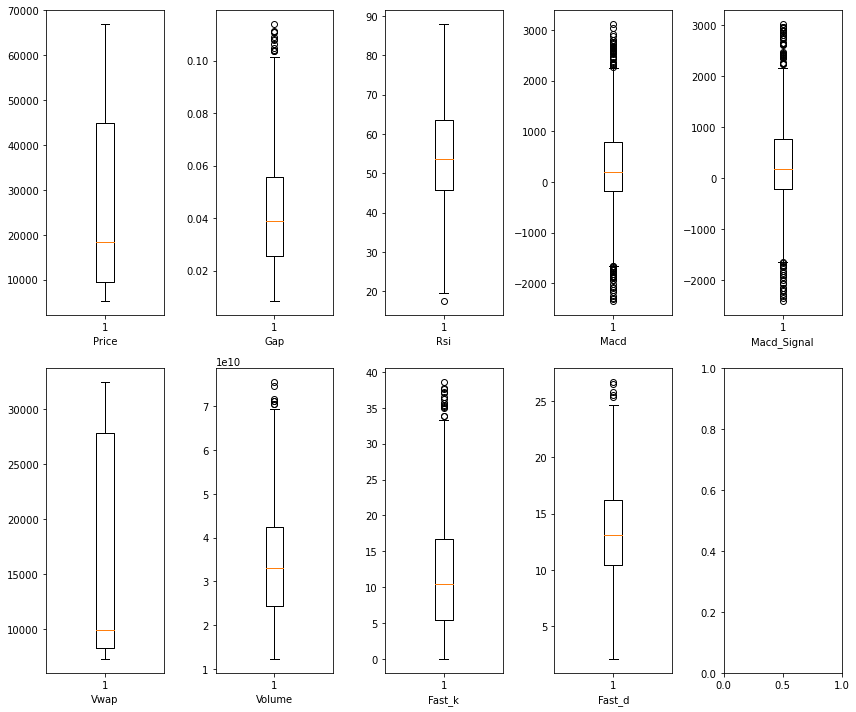

In [63]:
fig,axes = plt.subplots(2,5,figsize=(12,10))
for i, c in enumerate(df.columns,start=1):
    plt.subplot(2,5,i)
    plt.boxplot(df[c])
    plt.xlabel(c)
plt.tight_layout()

아웃라이어들이 제거된 것을 확인할 수 있다.

모델을 생성하고 비교해보자.

In [64]:
ridge_model = Pipeline([
    ("poly_features",PolynomialFeatures(degree=4, include_bias=True)),
    ('std_scaler', StandardScaler()),
    ('regulator', Ridge(alpha=10,solver="cholesky",random_state=42))
])
lasso_model = Pipeline([
    ("poly_features",PolynomialFeatures(degree=4, include_bias=True)),
    ('std_scaler', StandardScaler()),
    ('regulator', Lasso(alpha=10,random_state=42,fit_intercept=True))
])
rf_model = Pipeline([
    ('std_scaler', StandardScaler()),
    ('machine',RandomForestRegressor(bootstrap=True, random_state=42, oob_score=True))
])

In [67]:
def create_train_data(df):
    X = df.drop(['Price'],axis=1)
    y = df['Price'] #비트코인의 봉 평균가.
    train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=0.3,random_state=24)
    return train_X, test_X, train_y, test_y

In [68]:
train_X, test_X, train_y, test_y = create_train_data(df)
# ridge_model.fit(train_X, train_y)
# lasso_model.fit(train_X, train_y)

In [69]:
def find_best_alpha(train_X, train_y, test_X, test_y, model):
    best_alpha = 1
    best_mse = float('inf')
    for i in [1000,300,100,30,10,1]:
        model.set_params(regulator__alpha=i)
        model.fit(train_X, train_y)
        pred = model.predict(test_X)
        mse = ((test_y - pred) ** 2).mean()
        if best_mse > mse:
            best_mse = mse
            best_alpha = i
        print(f'mse: {mse}, alpha: {i}')
    return best_alpha
    
r_alpha = find_best_alpha(train_X, train_y, test_X, test_y, ridge_model)
ridge_model.set_params(regulator__alpha=r_alpha)
ridge_model.fit(train_X, train_y)

l_alpha = find_best_alpha(train_X, train_y, test_X, test_y, lasso_model)
lasso_model.set_params(regulator__alpha=l_alpha)
lasso_model.fit(train_X, train_y)



mse: 36315672.32405636, alpha: 1000
mse: 23356960.221757565, alpha: 300
mse: 17109549.30802138, alpha: 100
mse: 13691103.521585071, alpha: 30
mse: 12045973.505492631, alpha: 10
mse: 11593881.941287776, alpha: 1
mse: 25448025.4917426, alpha: 1000
mse: 20230341.249130495, alpha: 300


/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22516727.9220953, tolerance: 16257832.266398584
  model = cd_fast.enet_coordinate_descent(
/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 86866308.06501293, tolerance: 16257832.266398584
  model = cd_fast.enet_coordinate_descent(
/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 382010751.8789301, tolerance: 16257832.266398584
  model = cd_fast.enet_coordinate_descent(


mse: 14002029.058334544, alpha: 100
mse: 11671641.467214493, alpha: 30
mse: 10423849.48786874, alpha: 10
mse: 12419655.98738774, alpha: 1


/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 878474281.1238382, tolerance: 16257832.266398584
  model = cd_fast.enet_coordinate_descent(
/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 382010751.8789301, tolerance: 16257832.266398584
  model = cd_fast.enet_coordinate_descent(


Pipeline(steps=[('poly_features', PolynomialFeatures(degree=4)),
                ('std_scaler', StandardScaler()),
                ('regulator', Lasso(alpha=10, random_state=42))])

In [70]:
def visualize(pred,target,name):
    plt.figure(figsize=(20,12))
    index = np.arange(len(target))
    plt.scatter(index, target,label='target')
    plt.scatter(index, pred,label='model')
    mse = np.mean((target - pred) ** 2)
    plt.suptitle(f'{name}',fontsize=20)
    plt.title(f'MSE is {mse:.1f}')
    plt.legend()

In [71]:
r_pred = ridge_model.predict(test_X)
l_pred = lasso_model.predict(test_X)

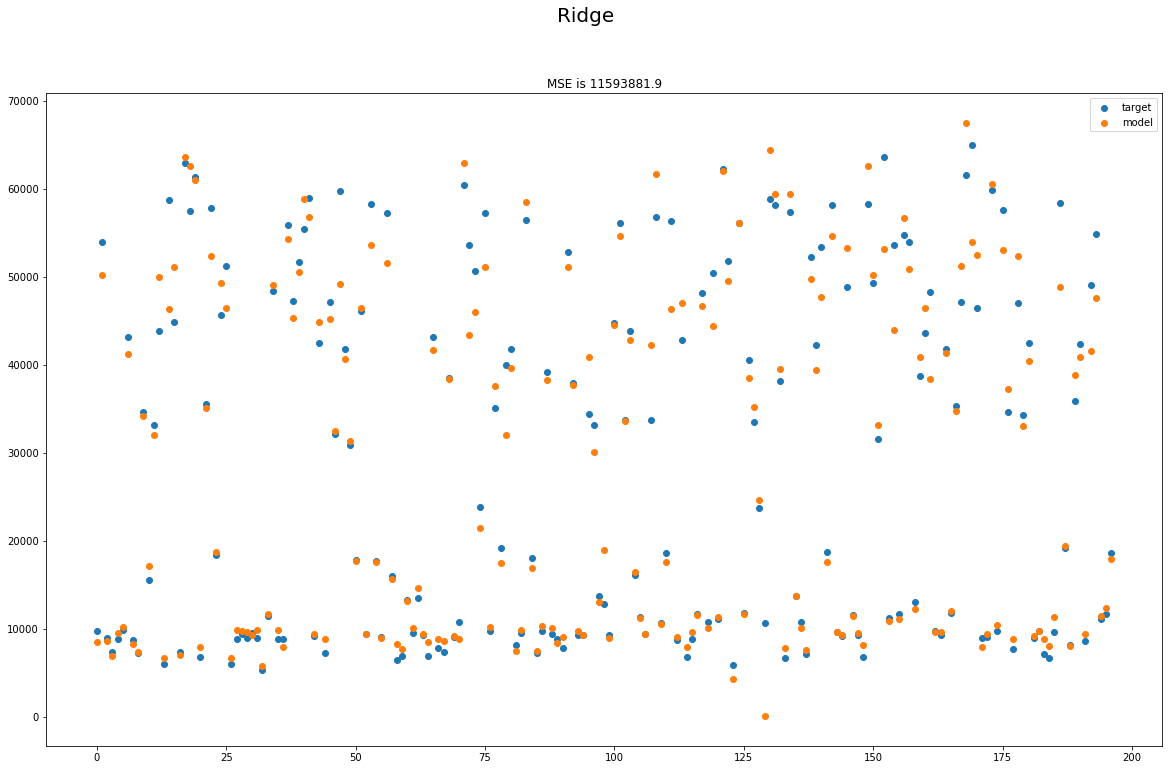

In [72]:
visualize(r_pred,test_y,"Ridge")

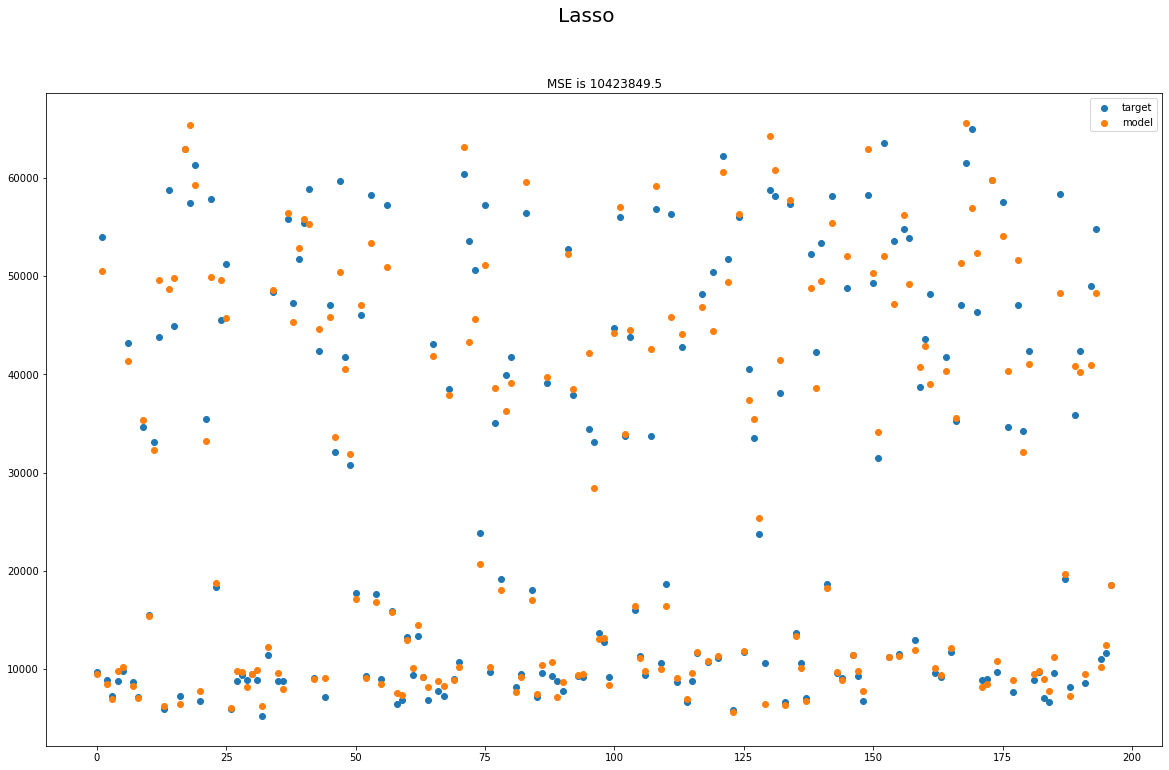

In [73]:
visualize(l_pred, test_y, "Lasso")

In [74]:
def visualize_plot(pred,target,name):
    pred = pd.Series(pred, index=target.index)
    plt.figure(figsize=(12,10))
    pred.sort_index().plot(label='model')
    test_y.sort_index().plot(label='target')
    plt.title(name)
    plt.legend()


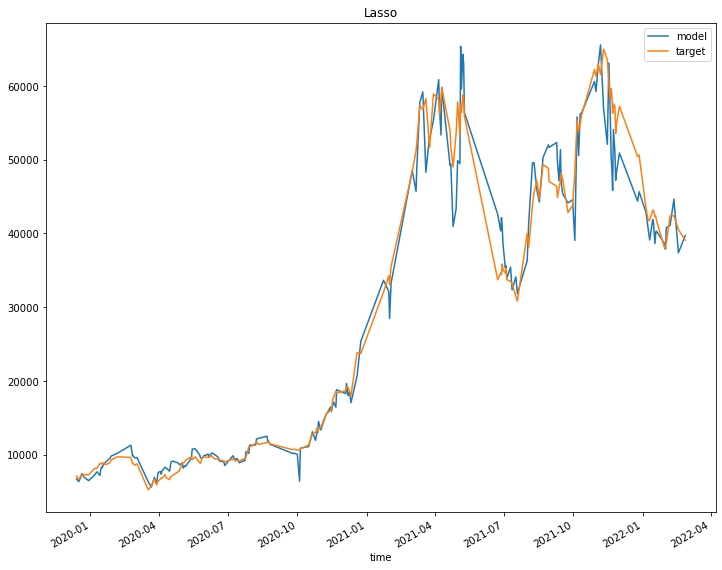

In [75]:
visualize_plot(l_pred, test_y, 'Lasso')

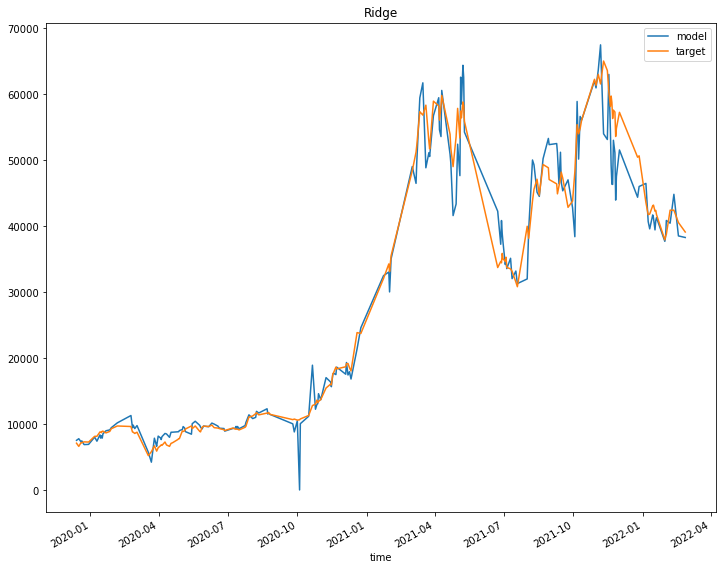

In [76]:
visualize_plot(r_pred, test_y, "Ridge")

릿지랑 라소는 예측률이 썩 좋지 못하다. 릿지와 라쏘를 사용하기엔 문제가 있을 듯 하다.

In [77]:
rf_model.fit(train_X, train_y)
rf_pred = rf_model.predict(test_X)

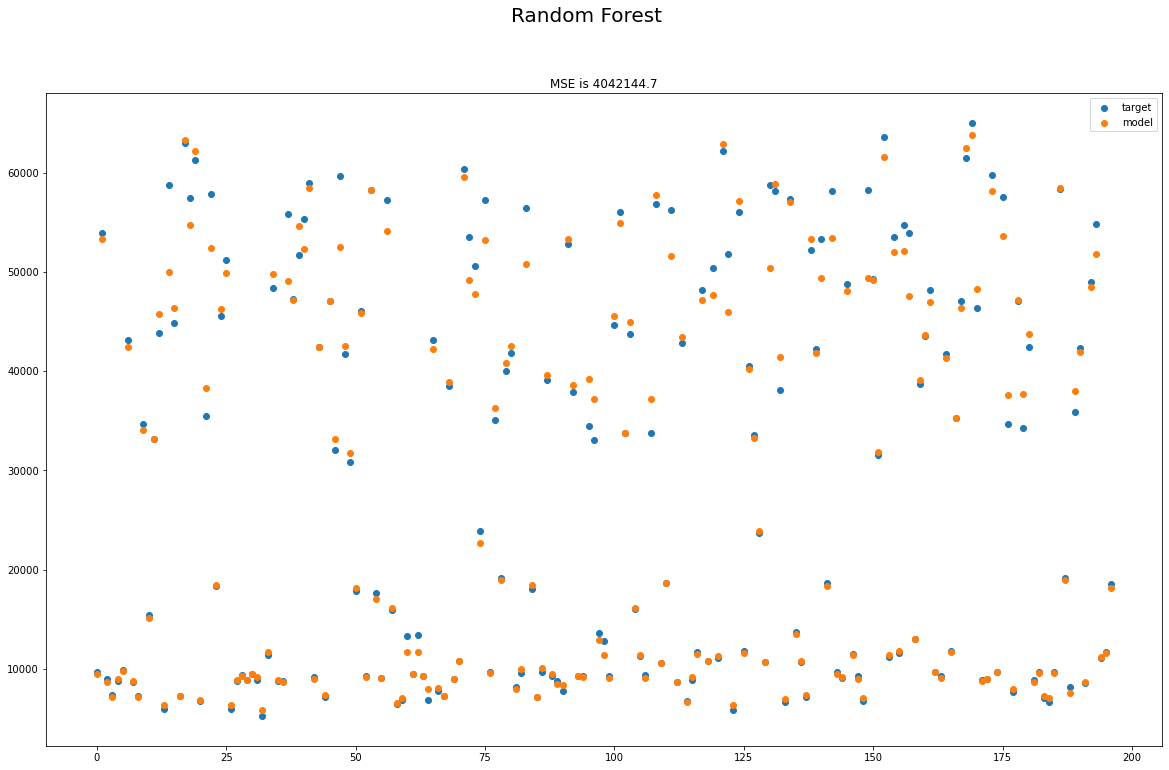

In [78]:
visualize(rf_pred, test_y, "Random Forest")

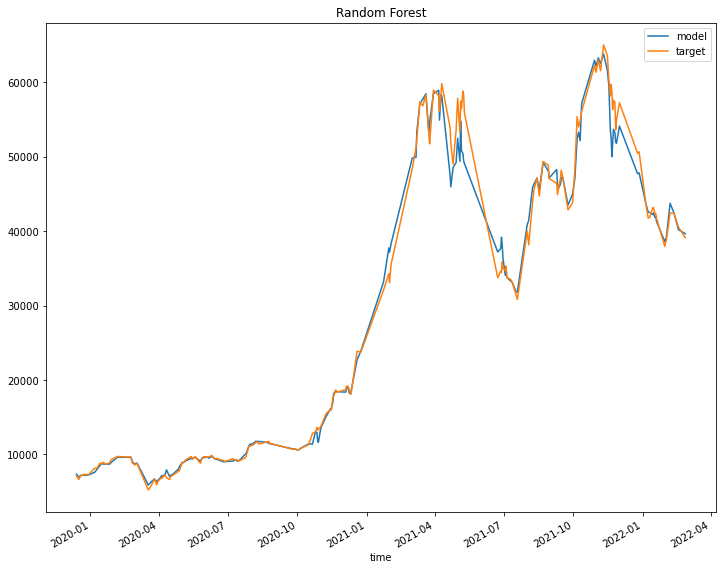

In [79]:
visualize_plot(rf_pred, test_y, "Random Forest")